# Анализ датасета Iris с помощью реализованной с нуля нейронной сети

Используем скрипт для генерации нейросети произвольной архитектуры; получим многослойный перцептрон и попробуем решить задачу многоклассовой классификации

## 1. Загрузка и преобразование данных

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from defaultlist import defaultlist
import matplotlib.pyplot as plt
%matplotlib inline


Загрузим датасет и посмотрим на представлениe данных, чтобы преобразовать их в датафрейм.

In [2]:
omg=load_iris()
omg

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

Получим датафрейм:

In [3]:
df = pd.DataFrame(data=np.c_[omg.data, omg.target],columns=([i[:-4] for i in omg['feature_names']] + ['target']))
df

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


Разделим датасет на признаки и целевые переменные. Подготовим данные, разделим их на обучающую и тестовую выборки.

In [4]:
Y = df.target
X = df.iloc[:, [0, 1, 2, 3]]

In [5]:
random_state = 42
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)

## 2. Реализация модели перцептрона

Напишем класс, позволяющий сгенерировать нейронную сеть любой глубины и с любой шириной каждого скрытого слоя. У нас будет два публичных метода - fit и predict.

In [6]:
class MPerceptron:
    """
    Модель многослойного перцептрона с динамической архитектурой сети.
    """
    def __init__(self,
                 hidden_net: list = [10],  # Structure of hidden layers
                 learning_rate: float=0.01,  # Speed
                 max_epochs: int=100,  # Количество эпох
                 random_state=100,
                 gamma=0.9,  # For RMSP method
                 epsilon=10 ** (-3),  # For RMSP method
                 start_loc=0.0,
                 start_scale=0.0002
                 ):
        self. hidden_net =  hidden_net
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.random_state = random_state
        self.gamma = gamma
        self.epsilon = epsilon  # сглаживающий параметр для RSMProp
        self.loc = start_loc
        self.scale = start_scale

    def __create_start_weight(self, dimension: tuple[int],
                              loc, scale) -> list[np.array]:
        """
        Инициализация весов в начале обучения.
        dimension --> W = [ w0, w1, w2, w3, w4 ],
        где w0 (OR b) - член смещения
    """

        rgen = np.random.RandomState(self.random_state)
        # Начальные веса и член смещения - в одном векторе
        return  rgen.normal(loc=loc, scale=scale, size=dimension)
    
    @staticmethod
    def __show_architecture(layers):
        return (f'- входной слой: {layers[0]}',
            *[f"скрытый слой шириной {h}" for h in layers[1:-1]],
              f'выходной слой {layers[-1]}')

    def __build_net_architecture(self, input_dim, output_dim) -> None:
        """
        Function takes info about hidden layers and helps program to create it
        Мы подаём на вход список: его длина - количество скрытых слоёв, а значение каждого элемента - ширина соответствующего слоя.
        Для каждого слоя генерируем начальные веса - матрицу соответствующей размерности
        """
        layers = [input_dim, *self.hidden_net, output_dim]
        print(*self.__show_architecture(layers), sep='\n- ') # length and depth
        weights = []
        # Размерность матрицы весов определяется шириной слоя, который подаётся на вход (это количество столбцов),
        # и шириной следующего слоя (это количество строк)
        for input_dim, output_dim in zip(
                layers[:-1], layers[1:]  # Получаем пары (слой, следующий слой)

        ):
            # К размерности входного слоя мы прибавляем единицу - так мы учитываем ФИКТИВНЫЙ столбец
            weights.append(
                self.__create_start_weight((output_dim, input_dim + 1), loc=self.loc, scale=self.scale)
            )
        # В итоге мы имеем m+1 весов для m скрытых слоёв.
        self.W = weights

    @staticmethod
    def __extend_matrix(A) -> pd.DataFrame:
        """
        Функция для добавления фиктивного единичного вектора
        к матрице
        """
        # Будем работать с локальной копией, чтобы не менять исходный датафрейм
        A = A.copy()
        A.insert(0, 'fictive', 1)
        return A

    @staticmethod
    def __convert_target(Y) -> pd.DataFrame:
        """
        Функция для преобразования истинных меток методом One-hot Encoding. Принимает
        вектор выходных переменных и возвращает матрицу, где стобцы - все уникальные значения.
        Вообще, этот метод подразумевает k-1 столбцов для k уникальных значений во избежание мультиколлинеарности.
        Однако же, мы просто хотим расширить наш вектор Y до матрицы, чтобы можно было искать градиент, поэтому drop_first=False.
        """
        Y = Y.copy()
        return pd.get_dummies(Y, drop_first=False, dummy_na=False, dtype='float')

    @staticmethod
    def __relu(T) -> pd.DataFrame:
        """
        Функция активации RELU.
        T --> output H(T)
        """
        return np.maximum(T, 0)

    @staticmethod
    def __relu_deriv(T) -> pd.DataFrame:
        """
        Производная функции активации, необходима для поиска градиента.
        Сравниваем все значения датафрейма T с нулём - получаем матрицу с True и False, эти значения переводим в бинарные значения
        """
        return (T >= 0).astype(float, copy=True)

    @staticmethod
    def __softmax(array) -> pd.DataFrame:
        """ Converts a vector of K real numbers into a probability distribution of K possible outcomes"""
        P = []
        for item in array.iterrows():  # Item - одна строка датафрейма формата <(порядковый номер строки, Series)>
            e = np.exp(item[1])  # Получаем вектор всех значений для одного наблюдения
            P.append(e / np.sum(e))  # Делим вектор на сумму экспонент, получая вероятностное распределение
        return pd.DataFrame(P)

    @staticmethod
    def __CE_log_loss(Y, P):
        """
        Логарифмическая функция потерь - кросс-энтропия - для небинарной классификации:
        Получаем на вход две матрицы KxN - K классов (уникальных меток) на N образцов.
        Логарифмируем предсказанные вероятности, после перемножаем матрицы и получаем матрицу KxK;
        складываем все K^2 значений. Ставим минус, чтобы преобразовать функцию правдоподобия в функцию потерь

        """
        y = Y.to_numpy()
        p = P.to_numpy()
        return - np.array([np.log(p[:, i]).T @ y[:, i] for i in range(y.shape[1])]).sum()

    def __forward_prop(self, X) -> tuple[defaultlist, defaultlist, pd.DataFrame]:
        """ Расчёт выходного слоя"""
        HH = defaultlist()
        T = defaultlist()
        HH[0] = self.__extend_matrix(X)
        for layer in range(1, len(self.W) + 1):
            T[layer] = HH[layer - 1] @ self.W[layer - 1].T
            # H[layer] = __relu(T[layer])
            # HH[layer] = __extend_matrix(H[layer])
            HH[layer] = self.__extend_matrix(self.__relu(T[layer]))
        # На последнем слое вместо функции активации используем софтмакс
        P = self.__softmax(T[-1])
        return T, HH, P

    def __RMSProp(self, grad, i):
        """
        Функция обновления весов методом RMSProp
        Возвращает deltaW
        """
        # Root Mean Square Propagation
        self.E_[i] = self.gamma * self.E_[i] + (1 - self.gamma) * grad ** 2
        return grad / (np.sqrt(self.E_[i] + self.epsilon))

    def __backward_prop(self, T, HH, E) -> list[np.array]:
        dH = defaultlist()
        dW = defaultlist()
        dT = defaultlist()
        dT[len(self.W)] = (E).to_numpy()
        for layer in range(len(self.W) - 1, 0, -1):
            dW[layer] = dT[layer + 1].T @ HH[layer].to_numpy()
            dH[layer] = dT[layer + 1] @ self.W[layer][:, 1:]  # Вектор смещения не учитываем, чтобы совпадала размерность
            rd = self.__relu_deriv(T[layer]).to_numpy()
            dT[layer] = dH[layer] * rd
        dW[0] = dT[1].T @ HH[0].to_numpy()
        return dW


    def fit(self, X, Y):
        """ Функция для обучения модели"""
        self.loss_function = []
        # X = copy.deepcopy(X)
        Y = self.__convert_target(Y)  # Преобразование вектора в матрицу из K столбцов
        # Определим размерность входного и выходного слоёв
        output_dim, input_dim = Y.shape[1], X.shape[1]
        self.__build_net_architecture(input_dim, output_dim)  # 0.2 300 0.0005
        # self.E_ = [0 for _ in range(len(self.W)+1)]
        self.E_ = [0] * (len(self.W) + 1)
        for epoch in range(self.max_epochs):
            # Prediction
            X = X.sample(frac=1, random_state=self.random_state)
            Y = Y.sample(frac=1, random_state=self.random_state)

            T, HH, P = self.__forward_prop(X)

            # Функция издержек
            self.loss_function.append(self.__CE_log_loss(Y, P))
            # dE_dW1 = np.nan_to_num(dE_dW1)
            # dE_dW2 = np.nan_to_num(dE_dW2)

            dW = self.__backward_prop(
                T, HH,
                P-Y  # Матрица ошибки Е при данных весах
            )
            # Обновление весов
            for i in range(0, len(self.W)):
                rate = self.learning_rate * self.__RMSProp(dW[i], i)
                self.W[i] -= rate

        print(f'Model has been trained successfully!')
        
    def predict(self, X):
        return self.__forward_prop(X)[2].sort_index()

Чтобы обучить модель определённым образом, нужно выбрать соответсвующий алгоритм при создании модели

## 3. Метрики

Мы используем простой датасет, в котором различных меток поровну и нет задачи "поймать" редкие, аномальные значения. Найти процент правильно классифицированных образцов - отличный вариант для анализа точности модели. Так же мы сравним поведение функций издержек.

In [7]:
def calculate_scores(pred, target):
    """ Функция для оценки точности модели"""
    scores = 0
    for check, true in zip(pred, target):
        if float(check) == true:
            scores +=1
    return f'{scores/len(target)*100}%'

In [8]:
def show_loss(loss) -> None:
    """ Функция для отображения графика функции потерь"""
    plt.plot(loss)
    plt.title("LOSS")
    plt.show()

## 4. Обучение модели

Обучим модели перцептрона с одним, двумя и тремя скрытыми слоями

**1) Трёхслойный перцептрон**

In [28]:
model1 = MPerceptron(hidden_net=[10], learning_rate=0.001, max_epochs=400, random_state=random_state)
model1.fit(X_train, Y_train)

- входной слой: 4
- скрытый слой шириной 10
- выходной слой 3
Model has been trained successfully!


In [29]:
P1 = model1.predict(X)
# Для каждого образца выберём столбец с максимальной 
# вероятностью - номер столбца совпадёт с индексом класса, к которому должен относиться этот цветок (второй столбец для класса 1 и тд)
P1.to_numpy().argmax(axis=1).T

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

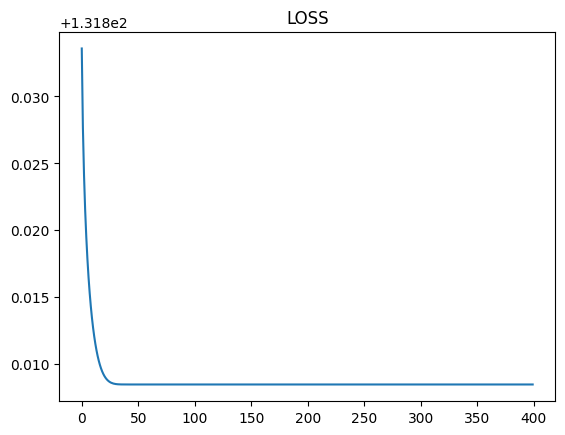

In [30]:
show_loss(model1.loss_function)

In [26]:
print("Model's accuracy is:  ", calculate_scores(P1.to_numpy().argmax(axis=1).T, Y))

Model's accuracy is:   98.0%


**2) Два скрытых слоя**

In [13]:
model2 = MPerceptron(hidden_net=[12, 9], learning_rate=0.0005, max_epochs=2300, random_state=random_state)
model2.fit(X_train, Y_train)

- входной слой: 4
- скрытый слой шириной 12
- скрытый слой шириной 9
- выходной слой 3
Model has been trained successfully!


In [14]:
P2 = model2.predict(X)

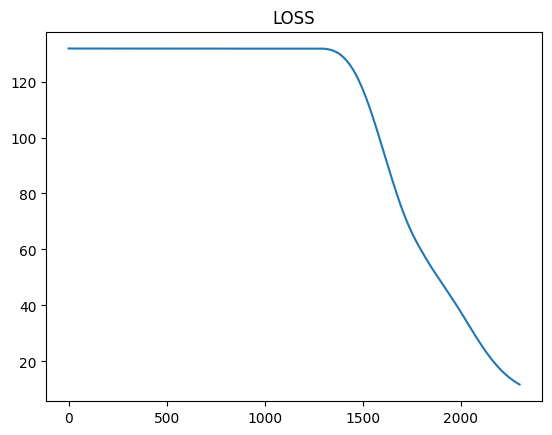

In [15]:
show_loss(model2.loss_function)

In [17]:
print("Model's accuracy is:  ", calculate_scores(P2.to_numpy().argmax(axis=1).T, Y))

Model's accuracy is:   98.0%


**3) Три скрытых слоя**

In [19]:
model3 = MPerceptron(hidden_net=[5, 5, 5], learning_rate=0.005, max_epochs=1800, random_state=random_state, start_scale=0.1)
model3.fit(X_train, Y_train)

- входной слой: 4
- скрытый слой шириной 5
- скрытый слой шириной 5
- скрытый слой шириной 5
- выходной слой 3
Model has been trained successfully!


In [20]:
P3 = model3.predict(X)

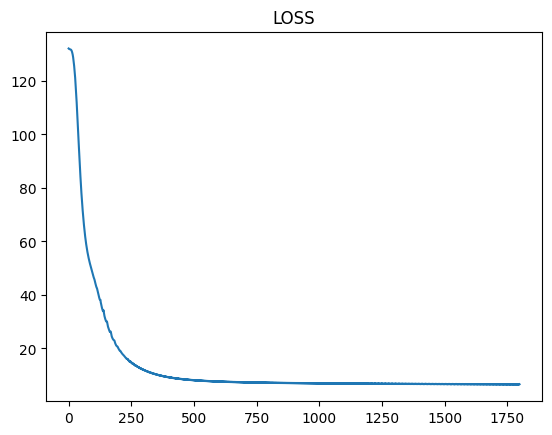

In [21]:
show_loss(model3.loss_function)

In [23]:
print("Model's accuracy is:  ", calculate_scores(P3.to_numpy().argmax(axis=1).T, Y))

Model's accuracy is:   98.0%


## 5. Вывод

**Все варианты нейронной сети достигают одинаково высокой точности. Соответственно, для решения задачи классификации на основе такого простого датасета, как ирисы, трёхслойного перцептрона более чем достаточно.**